In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
from mtcnn.mtcnn import MTCNN
import matplotlib.patches as patches
import random
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output
import imageio
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
DATASET_PATH ="lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "lfw_attributes.txt"

In [3]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("\\")[-2]
    dataset.append({"person":person, "path": path})
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Aaron_Eckhart,lfw-deepfunneled/lfw-deepfunneled\Aaron_Eckhar...
1,Aaron_Guiel,lfw-deepfunneled/lfw-deepfunneled\Aaron_Guiel\...
2,Aaron_Patterson,lfw-deepfunneled/lfw-deepfunneled\Aaron_Patter...
3,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
4,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
5,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
6,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
7,Aaron_Pena,lfw-deepfunneled/lfw-deepfunneled\Aaron_Pena\A...
8,Aaron_Sorkin,lfw-deepfunneled/lfw-deepfunneled\Aaron_Sorkin...
9,Aaron_Sorkin,lfw-deepfunneled/lfw-deepfunneled\Aaron_Sorkin...


<AxesSubplot: xlabel='person'>

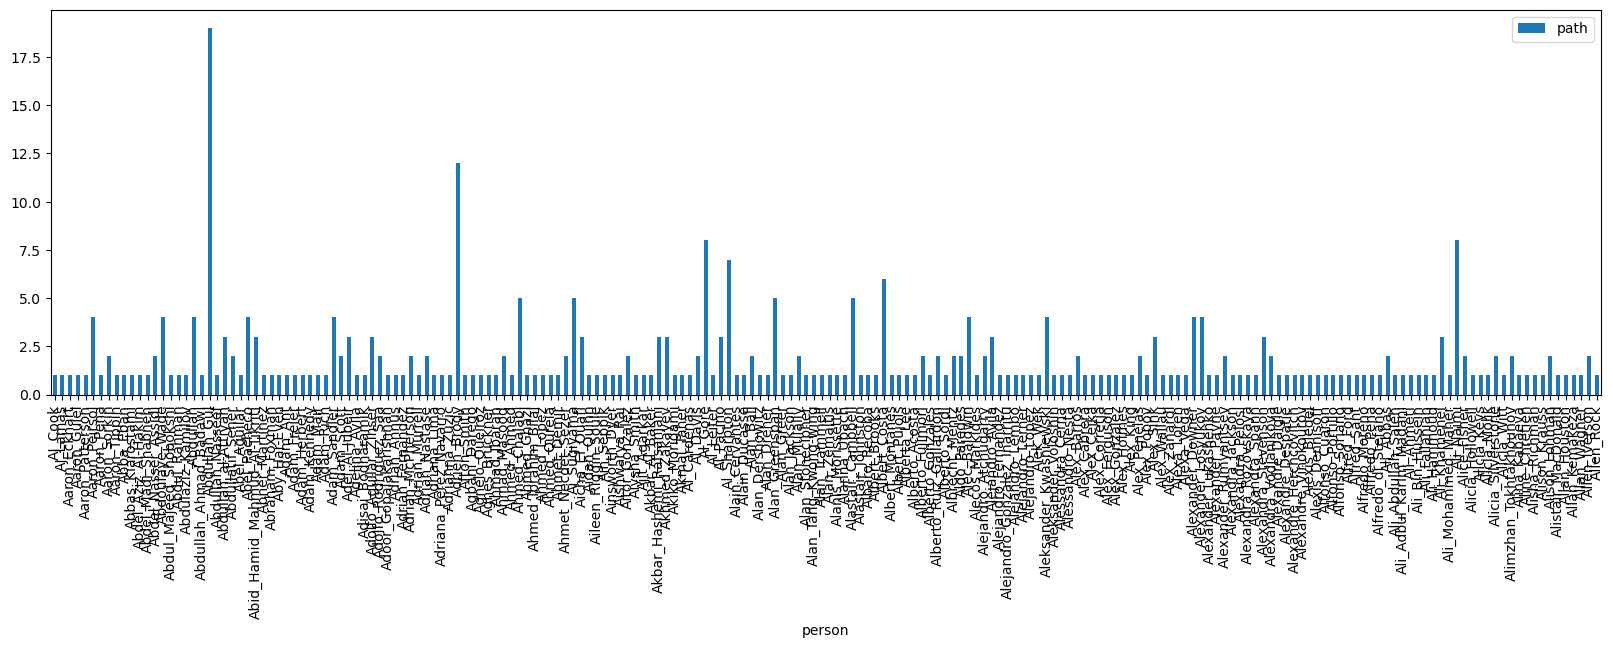

In [4]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

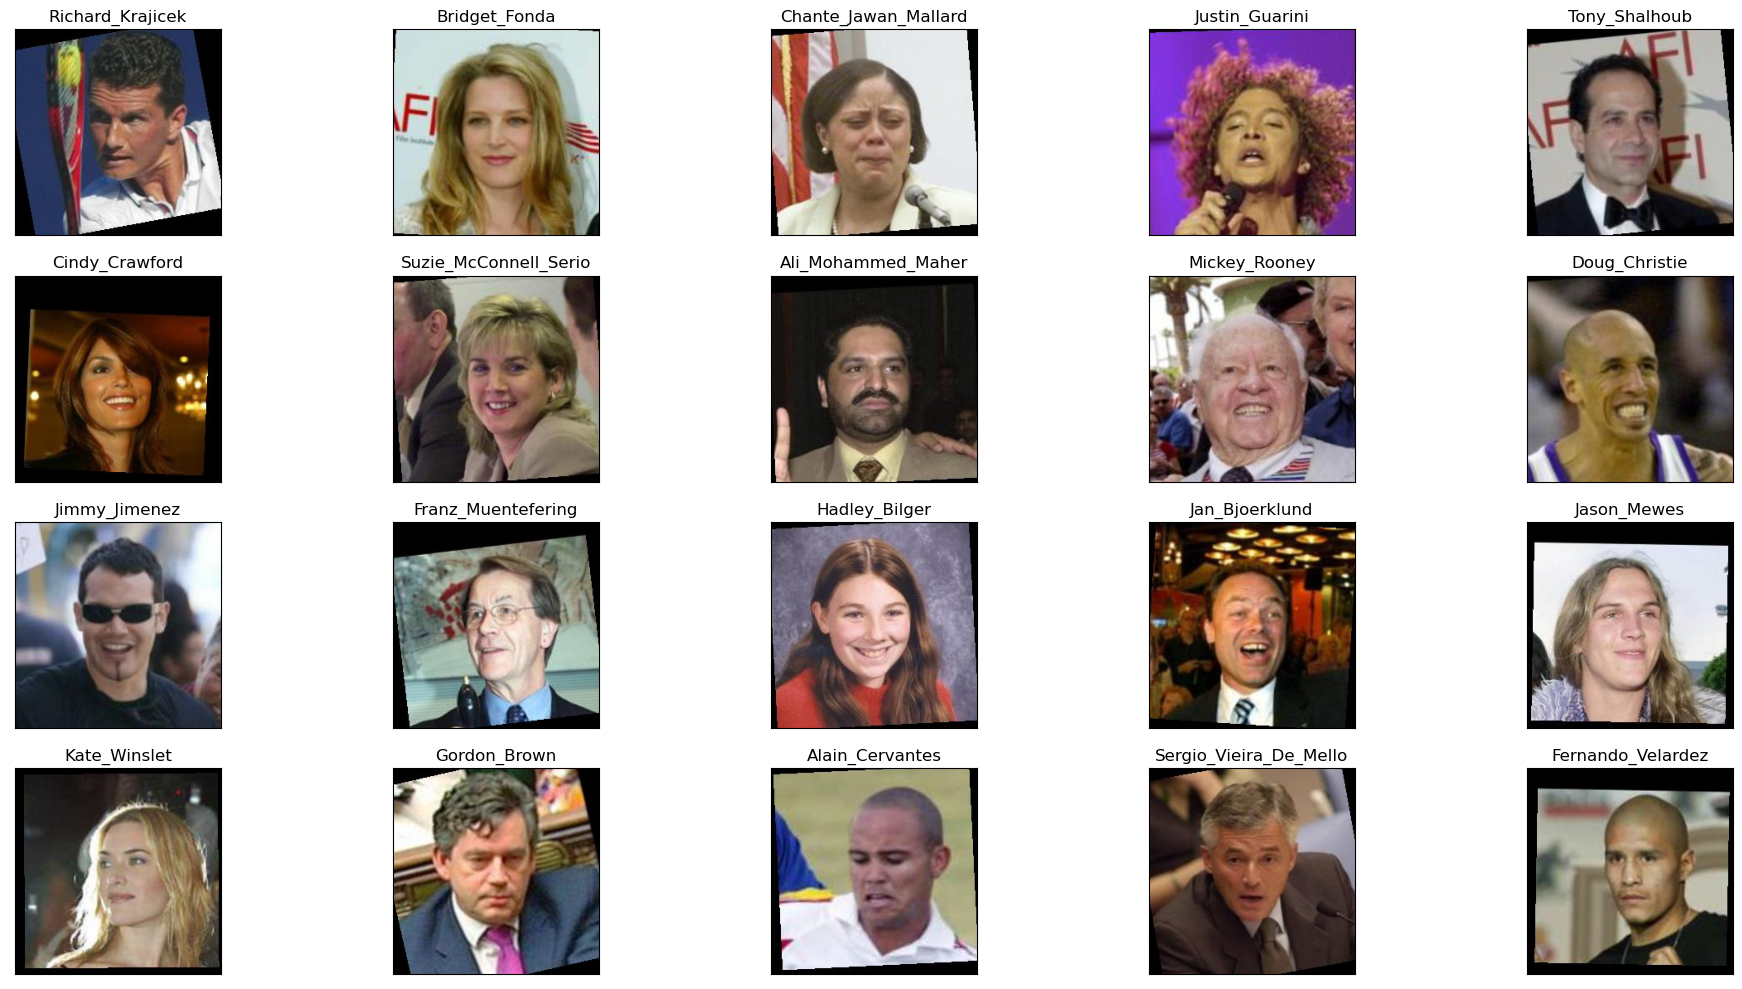

In [5]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [6]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs



In [10]:
data, attrs = fetch_dataset()

In [11]:
#45,45
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

In [12]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

## Define AAE

In [14]:
X_train = X_train.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)

In [16]:
dim_z = 100

class AAE(nn.Module):
    def __init__(self):
        super(AAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.discriminator = Discriminator(dim_z)

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        disc_pred = self.discriminator(z)
        return recon_x, z, disc_pred

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc2 = nn.Linear(1500, dim_z)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = x.view(-1, 45*45*3)
        x = self.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(dim_z, 1500)
        self.fc2 = nn.Linear(1500, 45*45*3)
        self.relu = nn.LeakyReLU()

    def forward(self, z):
        z = self.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(z))
        x_recon = x_recon.view(-1, 3, 45, 45)
        return x_recon

class Discriminator(nn.Module):
    def __init__(self, z_dim):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(z_dim, 500),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(500, 250),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(250, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.main(z)

def loss_aae(x, recon_x, z, disc_pred, real_labels, fake_labels):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 45*45*3), x.view(-1, 45*45*3), reduction='sum')
    disc_loss = F.binary_cross_entropy(disc_pred, real_labels)
    gen_loss = F.binary_cross_entropy(disc_pred, fake_labels)
    return recon_loss, disc_loss, gen_loss

In [18]:
# 定义训练参数
batch_size = 64
epochs = 50
lr = 1e-3

# 准备数据
train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 初始化模型和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AAE().to(device)
optimizer_gen = optim.Adam(model.encoder.parameters(), lr=lr)
optimizer_disc = optim.Adam(model.discriminator.parameters(), lr=lr)
optimizer_dec = optim.Adam(model.decoder.parameters(), lr=lr)

## Train AAE

In [19]:
def train_aae(model, train_loader, optimizer_gen, optimizer_disc, optimizer_dec, device):
    model.train()
    total_recon_loss, total_disc_loss, total_gen_loss = 0, 0, 0

    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        real_labels = torch.ones(data.size(0), 1).to(device)
        fake_labels = torch.zeros(data.size(0), 1).to(device)

        # 更新判别器
        optimizer_disc.zero_grad()
        recon_data, latent_z, disc_pred = model(data)
        disc_loss = F.binary_cross_entropy(disc_pred, real_labels)
        disc_loss.backward()
        optimizer_disc.step()

        # 更新生成器
        optimizer_gen.zero_grad()
        recon_data, latent_z, disc_pred = model(data)
        gen_loss = F.binary_cross_entropy(disc_pred, real_labels)
        gen_loss.backward()
        optimizer_gen.step()

        # 更新解码器
        optimizer_dec.zero_grad()
        recon_data, latent_z, _ = model(data)
        recon_loss = F.binary_cross_entropy(recon_data.view(-1, 45*45*3), data.view(-1, 45*45*3), reduction='sum')
        recon_loss.backward()
        optimizer_dec.step()

        total_recon_loss += recon_loss.item()
        total_disc_loss += disc_loss.item()
        total_gen_loss += gen_loss.item()

    total_recon_loss /= len(train_loader.dataset)
    total_disc_loss /= len(train_loader.dataset)
    total_gen_loss /= len(train_loader.dataset)

    return total_recon_loss, total_disc_loss, total_gen_loss

epoch:   2%|█▌                                                                          | 1/50 [00:04<03:47,  4.64s/it]


Epoch 001 train_loss: 0.0293 val_loss: 0.0158


epoch:   4%|███                                                                         | 2/50 [00:06<02:23,  2.98s/it]


Epoch 002 train_loss: 0.0123 val_loss: 0.0116


epoch:   6%|████▌                                                                       | 3/50 [00:08<01:55,  2.45s/it]


Epoch 003 train_loss: 0.0106 val_loss: 0.0116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:   8%|██████                                                                      | 4/50 [00:10<01:42,  2.22s/it]


Epoch 004 train_loss: 0.0097 val_loss: 0.0092


epoch:  10%|███████▌                                                                    | 5/50 [00:12<01:35,  2.12s/it]


Epoch 005 train_loss: 0.0091 val_loss: 0.0088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  12%|█████████                                                                   | 6/50 [00:13<01:29,  2.03s/it]


Epoch 006 train_loss: 0.0085 val_loss: 0.0083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  14%|██████████▋                                                                 | 7/50 [00:15<01:23,  1.95s/it]


Epoch 007 train_loss: 0.0082 val_loss: 0.0085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  16%|████████████▏                                                               | 8/50 [00:17<01:20,  1.91s/it]


Epoch 008 train_loss: 0.0078 val_loss: 0.0078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  18%|█████████████▋                                                              | 9/50 [00:19<01:16,  1.87s/it]


Epoch 009 train_loss: 0.0075 val_loss: 0.0076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  20%|███████████████                                                            | 10/50 [00:21<01:14,  1.87s/it]


Epoch 010 train_loss: 0.0073 val_loss: 0.0073


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  22%|████████████████▌                                                          | 11/50 [00:23<01:12,  1.87s/it]


Epoch 011 train_loss: 0.0072 val_loss: 0.0076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  24%|██████████████████                                                         | 12/50 [00:24<01:11,  1.88s/it]


Epoch 012 train_loss: 0.0071 val_loss: 0.0072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  26%|███████████████████▌                                                       | 13/50 [00:26<01:08,  1.86s/it]


Epoch 013 train_loss: 0.0067 val_loss: 0.0068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  28%|█████████████████████                                                      | 14/50 [00:28<01:06,  1.85s/it]


Epoch 014 train_loss: 0.0066 val_loss: 0.0068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  30%|██████████████████████▌                                                    | 15/50 [00:30<01:04,  1.84s/it]


Epoch 015 train_loss: 0.0063 val_loss: 0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  32%|████████████████████████                                                   | 16/50 [00:32<01:02,  1.83s/it]


Epoch 016 train_loss: 0.0061 val_loss: 0.0067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  34%|█████████████████████████▌                                                 | 17/50 [00:34<01:00,  1.84s/it]


Epoch 017 train_loss: 0.0061 val_loss: 0.0073


epoch:  36%|███████████████████████████                                                | 18/50 [00:35<00:58,  1.84s/it]


Epoch 018 train_loss: 0.0062 val_loss: 0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  38%|████████████████████████████▌                                              | 19/50 [00:37<00:56,  1.82s/it]


Epoch 019 train_loss: 0.0058 val_loss: 0.0069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  40%|██████████████████████████████                                             | 20/50 [00:39<00:54,  1.82s/it]


Epoch 020 train_loss: 0.0058 val_loss: 0.0062


C:\Users\PC\AppData\Local\Temp\ipykernel_20792\1030000551.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

epoch:  42%|███████████████████████████████▌                                           | 21/50 [00:41<00:52,  1.81s/it]


Epoch 021 train_loss: 0.0057 val_loss: 0.0061


epoch:  44%|█████████████████████████████████                                          | 22/50 [00:43<00:50,  1.81s/it]


Epoch 022 train_loss: 0.0057 val_loss: 0.0063


epoch:  46%|██████████████████████████████████▌                                        | 23/50 [00:44<00:48,  1.81s/it]


Epoch 023 train_loss: 0.0055 val_loss: 0.0063


epoch:  48%|████████████████████████████████████                                       | 24/50 [00:46<00:46,  1.81s/it]


Epoch 024 train_loss: 0.0054 val_loss: 0.0062


epoch:  50%|█████████████████████████████████████▌                                     | 25/50 [00:48<00:45,  1.82s/it]


Epoch 025 train_loss: 0.0053 val_loss: 0.0063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  52%|███████████████████████████████████████                                    | 26/50 [00:50<00:43,  1.81s/it]


Epoch 026 train_loss: 0.0054 val_loss: 0.0063


epoch:  54%|████████████████████████████████████████▌                                  | 27/50 [00:52<00:41,  1.80s/it]


Epoch 027 train_loss: 0.0054 val_loss: 0.0060


epoch:  56%|██████████████████████████████████████████                                 | 28/50 [00:53<00:39,  1.80s/it]


Epoch 028 train_loss: 0.0053 val_loss: 0.0059


epoch:  58%|███████████████████████████████████████████▌                               | 29/50 [00:55<00:38,  1.81s/it]


Epoch 029 train_loss: 0.0051 val_loss: 0.0063


epoch:  60%|█████████████████████████████████████████████                              | 30/50 [00:57<00:36,  1.84s/it]


Epoch 030 train_loss: 0.0051 val_loss: 0.0070


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  62%|██████████████████████████████████████████████▌                            | 31/50 [00:59<00:34,  1.84s/it]


Epoch 031 train_loss: 0.0051 val_loss: 0.0061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  64%|████████████████████████████████████████████████                           | 32/50 [01:01<00:33,  1.84s/it]


Epoch 032 train_loss: 0.0051 val_loss: 0.0064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  66%|█████████████████████████████████████████████████▌                         | 33/50 [01:03<00:31,  1.85s/it]


Epoch 033 train_loss: 0.0051 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  68%|███████████████████████████████████████████████████                        | 34/50 [01:05<00:29,  1.84s/it]


Epoch 034 train_loss: 0.0050 val_loss: 0.0063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  70%|████████████████████████████████████████████████████▌                      | 35/50 [01:07<00:28,  1.89s/it]


Epoch 035 train_loss: 0.0049 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  72%|██████████████████████████████████████████████████████                     | 36/50 [01:08<00:26,  1.86s/it]


Epoch 036 train_loss: 0.0049 val_loss: 0.0062


epoch:  74%|███████████████████████████████████████████████████████▌                   | 37/50 [01:10<00:24,  1.87s/it]


Epoch 037 train_loss: 0.0048 val_loss: 0.0063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  76%|█████████████████████████████████████████████████████████                  | 38/50 [01:12<00:22,  1.88s/it]


Epoch 038 train_loss: 0.0048 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  78%|██████████████████████████████████████████████████████████▌                | 39/50 [01:14<00:20,  1.88s/it]


Epoch 039 train_loss: 0.0048 val_loss: 0.0062


epoch:  80%|████████████████████████████████████████████████████████████               | 40/50 [01:16<00:18,  1.88s/it]


Epoch 040 train_loss: 0.0049 val_loss: 0.0062


epoch:  82%|█████████████████████████████████████████████████████████████▍             | 41/50 [01:18<00:16,  1.87s/it]


Epoch 041 train_loss: 0.0048 val_loss: 0.0063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  84%|███████████████████████████████████████████████████████████████            | 42/50 [01:20<00:14,  1.86s/it]


Epoch 042 train_loss: 0.0047 val_loss: 0.0066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  86%|████████████████████████████████████████████████████████████████▌          | 43/50 [01:21<00:12,  1.85s/it]


Epoch 043 train_loss: 0.0046 val_loss: 0.0067


epoch:  88%|██████████████████████████████████████████████████████████████████         | 44/50 [01:23<00:11,  1.88s/it]


Epoch 044 train_loss: 0.0045 val_loss: 0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 45/50 [01:26<00:09,  1.95s/it]


Epoch 045 train_loss: 0.0047 val_loss: 0.0067


epoch:  92%|█████████████████████████████████████████████████████████████████████      | 46/50 [01:28<00:08,  2.01s/it]


Epoch 046 train_loss: 0.0047 val_loss: 0.0067


epoch:  94%|██████████████████████████████████████████████████████████████████████▌    | 47/50 [01:30<00:06,  2.05s/it]


Epoch 047 train_loss: 0.0046 val_loss: 0.0065


epoch:  96%|████████████████████████████████████████████████████████████████████████   | 48/50 [01:32<00:04,  2.06s/it]


Epoch 048 train_loss: 0.0045 val_loss: 0.0067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  98%|█████████████████████████████████████████████████████████████████████████▌ | 49/50 [01:34<00:02,  2.06s/it]


Epoch 049 train_loss: 0.0044 val_loss: 0.0066


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [01:36<00:00,  1.93s/it]



Epoch 050 train_loss: 0.0045 val_loss: 0.0067


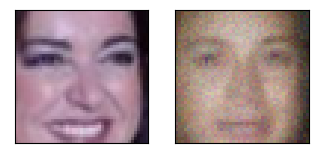

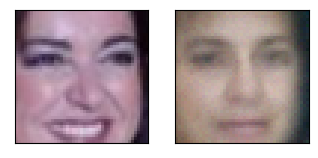

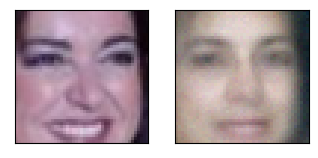

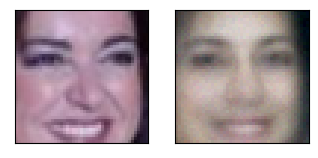

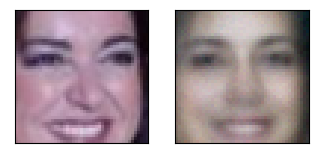

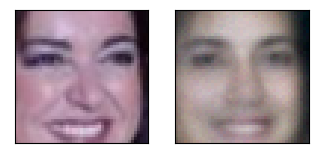

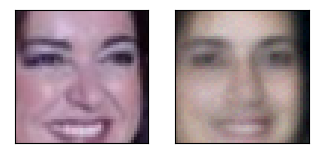

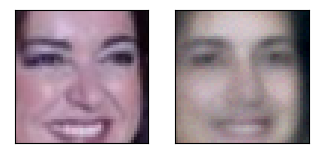

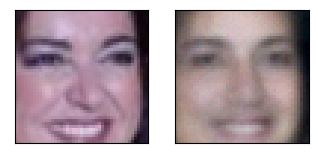

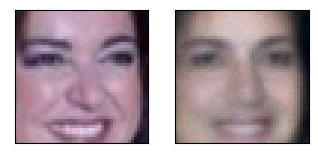

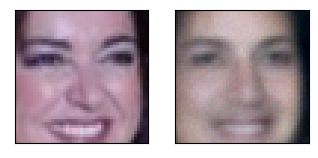

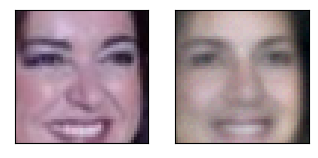

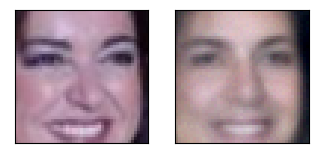

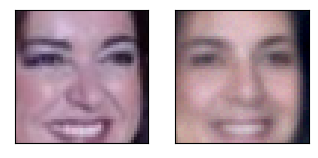

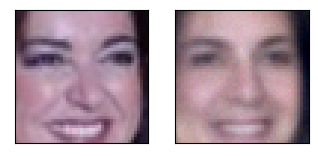

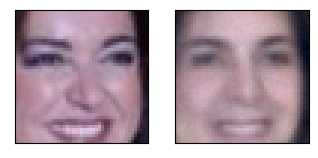

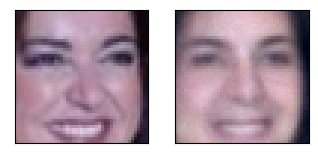

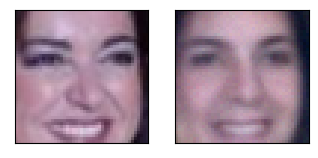

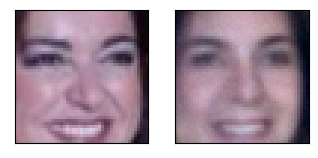

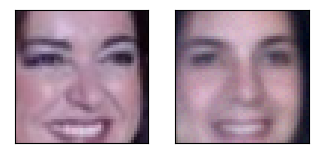

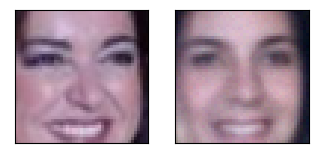

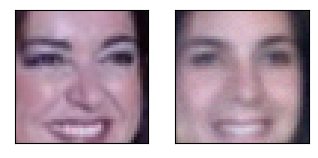

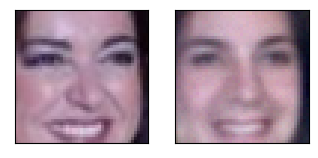

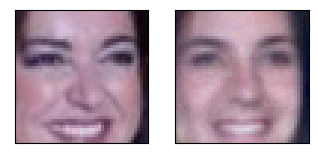

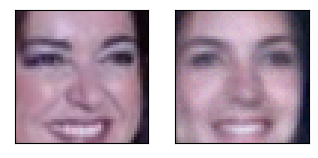

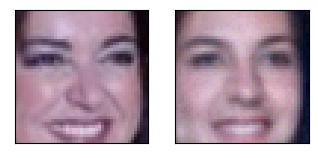

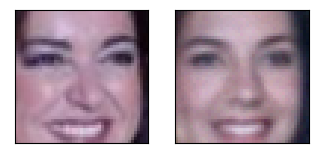

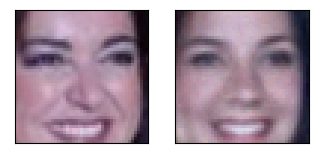

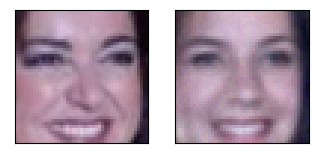

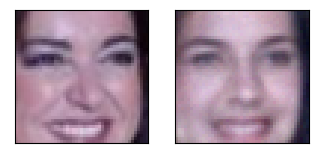

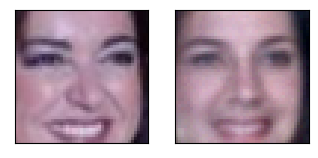

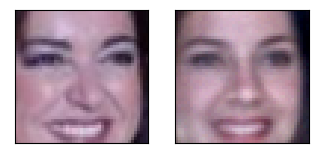

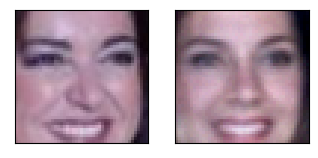

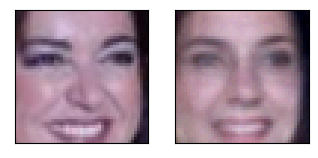

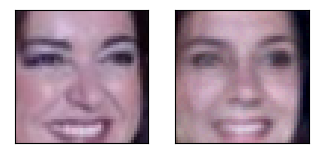

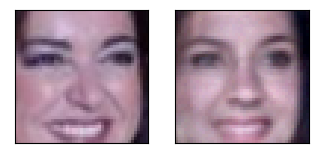

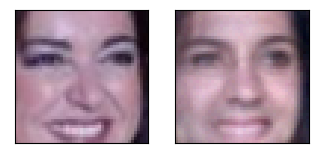

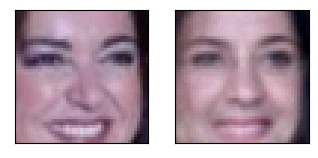

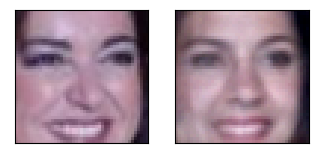

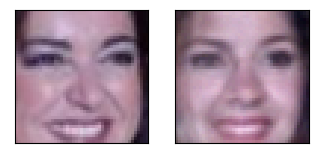

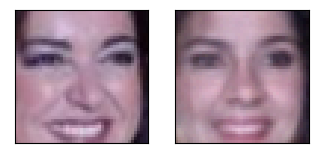

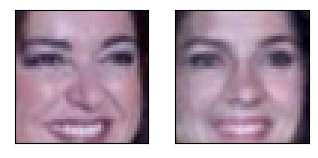

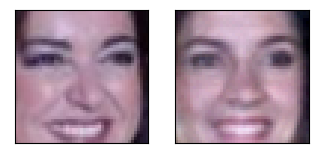

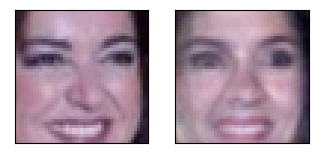

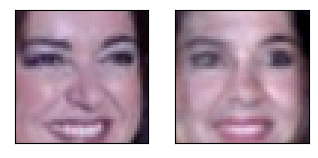

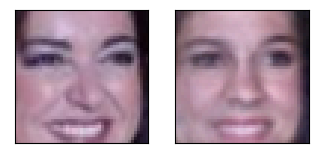

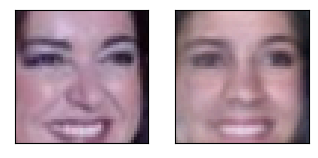

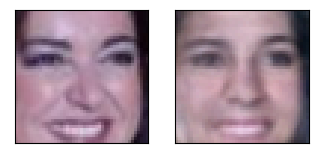

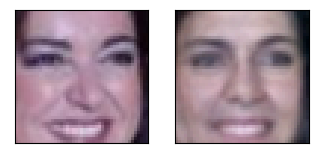

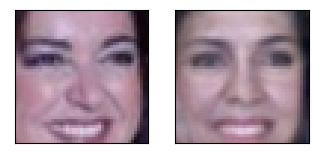

In [20]:
for epoch in range(1, epochs + 1):
    history = train(model, train_loader, optimizer_gen, optimizer_disc, optimizer_dec, device)
    

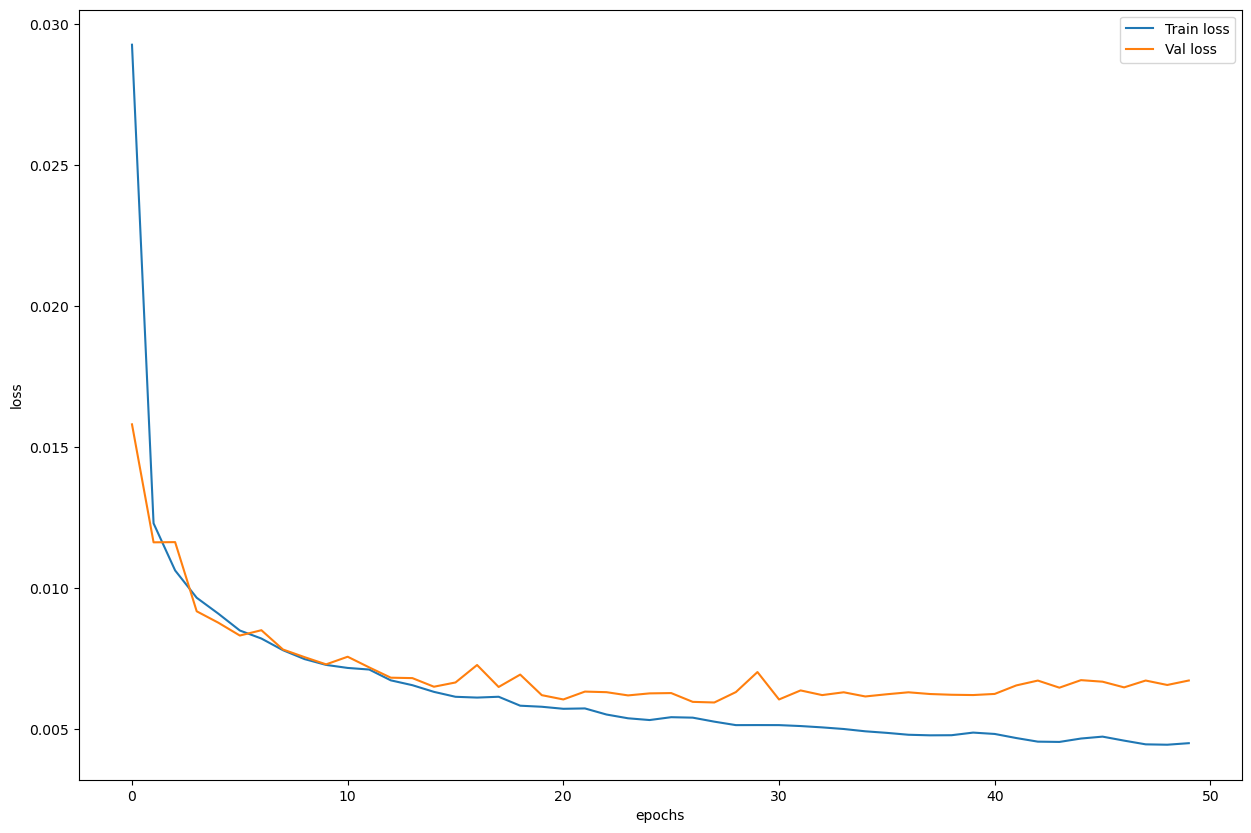

In [21]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

## 生成25张随机图像脸

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(25, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

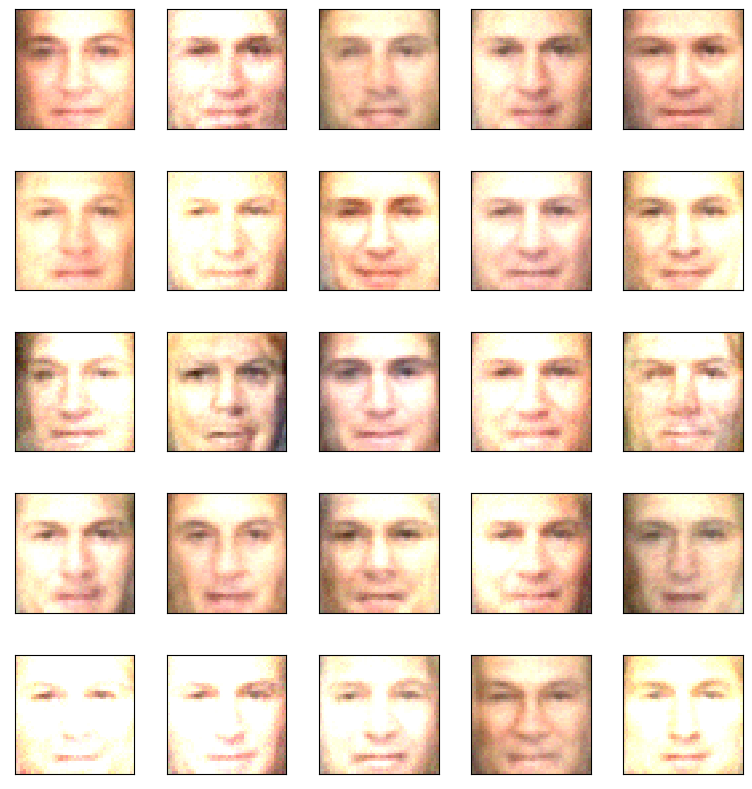

In [22]:
with torch.no_grad():
    z_sample = torch.randn(1, dim_z).to(device)
    generated_face = model.decoder(z_sample)
    generated_face = generated_face.permute(0,2,3,1)
    plot_gallery(generated_face.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## 添加眼镜和微笑

In [23]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [24]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [25]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

In [30]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model.eval()
        output = model.encode(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model.eval()
        output = model.decode(inputs)        
        return output

In [31]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
sunglasses_vec = sunglasses_latent - smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\P

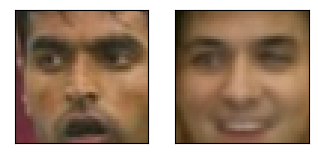

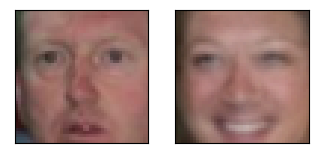

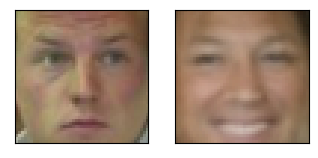

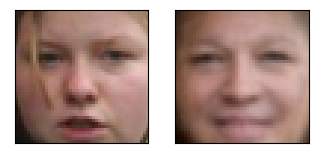

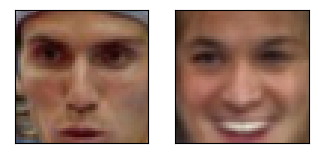

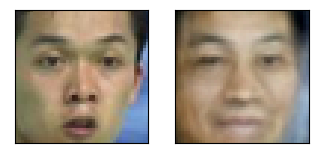

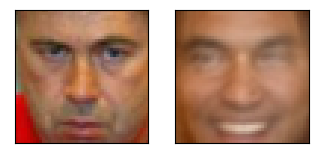

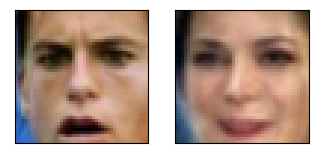

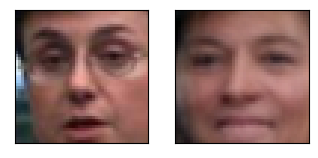

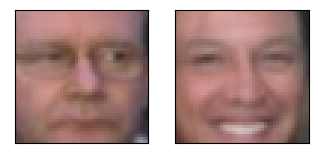

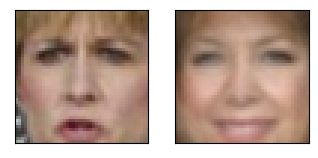

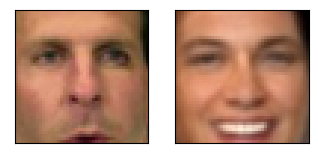

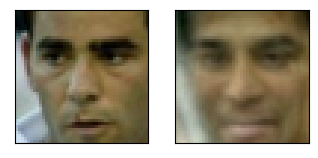

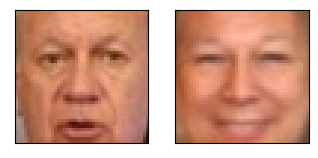

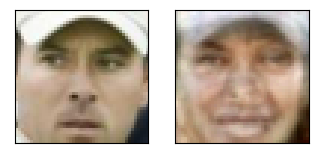

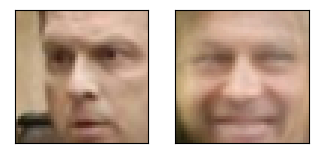

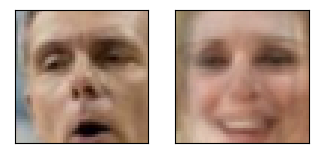

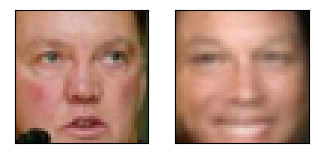

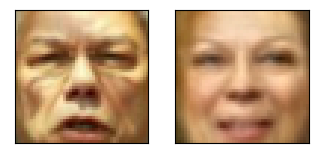

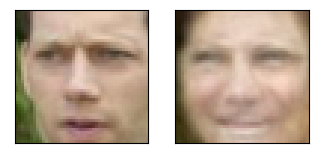

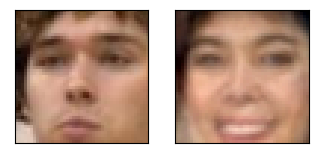

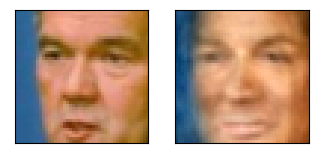

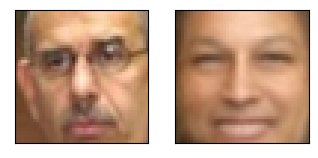

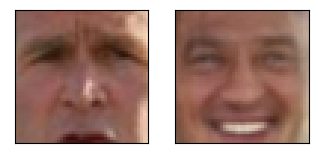

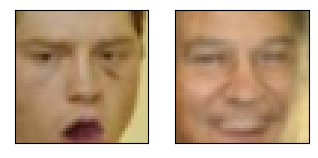

In [32]:
make_me_smile(no_smile_ids)